In [2]:
import ta.momentum
import ta.trend
import ta.volatility
import yfinance as yf
import ta
import numpy as np
from sklearn.preprocessing import StandardScaler
import gymnasium as gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from gymnasium import spaces


class DataLoader:
  def __init__(self, pair="BTC-USD", start='2022-01-01', end='2023-01-01', freq='1d'):
    self.pair = pair
    self.start = start
    self.end = end
    self.freq = freq
    
    self.yfLoad()
    
    self.scaler = StandardScaler()
    self.scaler.fit(self.data[:, 1:])

  def __len__(self):
      return len(self.data)
      
  def __getitem__(self, idx, col_idx=None):
      if col_idx is None:
        return self.data[idx]
      elif col_idx < len(list(self.data.columns)):
        return self.data[idx][col_idx]
      else:
        raise IndexError
    
  def yfLoad(self):
    df = yf.download([self.pair], start=self.start, end=self.end, interval=self.freq)
    

    df['next_day_reward'] = df['Adj Close'].pct_change().shift(-1)
    df['reward_day'] = df['Adj Close'].pct_change(1)
    
    rsi = ta.momentum.RSIIndicator(df['reward_day'], window=14)
    
    # bb = ta.volatility.BollingerBands(df['reward_day'], window=20, window_dev=2)

    macd = ta.trend.MACD(df['reward_day'], window_slow=26, window_fast=12, window_sign=9)

    df['RSI'] = rsi.rsi()
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['Volume_day_pct_change'] = df['Volume'].pct_change(1)


    # Bollinger Bands
    bollinger_lback = 20
    df["bollinger"] = df["reward_day"].ewm(bollinger_lback).mean()
    df["low_bollinger"] = df["bollinger"] - 2 * df["reward_day"].rolling(bollinger_lback).std()
    df["high_bollinger"] = df["bollinger"] + 2 * df["reward_day"].rolling(bollinger_lback).std()

    # Filtering
    for c in df.columns:
      df[c] = df[c].interpolate('linear', limit_direction='both')
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    self.frame = df
    
    # drop yfinance fetched values
    self.data = np.array(df.iloc[:, 6:])

    return self.data
  
  def scaleData(self):
    self.scaled_data = self.scaler.fit_transform(self.data[:, 1:])
    return self.scaled_data
  

In [3]:
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_budget=10000, budget_threshold = 0.1, investment_fraction = 0.1, tx_fee = 0.01):
        super(StockTradingEnv, self).__init__()
        
        self.data = data
        self.actions_data = pd.DataFrame({'Action': [0] * len(self.data)})

        self.budget_threshold = budget_threshold
        self.initial_budget = initial_budget  
        self.budget_remaining = self.initial_budget
        self.budget = self.initial_budget
        self.investment_fraction = investment_fraction
        self.tx_fee = tx_fee
        
        self.done_idx = len(self.data) - 1
        self.current_step = 0
        self.invested = 0
        self.previous_action = 0  # 0 = HOLD
        self.capital_history = []
    
        self.action_space = spaces.Discrete(3, start=-1)  # Actions: Buy, Hold, Sell
        self.observation_space = spaces.Box(
            low=-np.inf, high=+np.inf, 
            shape=(12,), 
            dtype=np.float32
        )

    def check_done(self):
        if self.current_step >= self.done_idx or self.budget <= self.initial_budget * self.budget_threshold:
            return True
        
        return False

    def calculate_reward(self, action, price):
        penalty = 0
        investment = self.budget_remaining * self.investment_fraction
        
        if action == 1:
            if self.budget_remaining > self.initial_budget * self.budget_threshold:
                self.budget_remaining -= investment
                self.invested += investment / price
            else:
                penalty += 0.5
        elif action == -1 and self.invested > 0: # Sell action
            self.budget_remaining += (self.invested * price) * (1 - self.tx_fee)
            self.invested = 0
        elif action == 0: # Hold action
            if self.previous_action == 0: # Penalty for holding
                penalty += 0.1
        
        # update budget, cause it changes with the price
        self.budget = self.budget_remaining + self.invested * price

        reward = 100 * self.next_return * action - np.abs(action - self.previous_action) * self.tx_fee
        
        if reward < 0:
            reward *= 1.5
            
        reward -= penalty
        
        return reward
 
    def get_state(self, idx, price):
        state = self.data[idx][1:]
        state = self.data.scaler.transform(state.reshape(1, -1))

        state = np.concatenate([state, [[self.budget/self.initial_budget,
                                        self.budget_remaining/self.budget,
                                        self.invested * price/self.initial_budget,
                                        self.previous_action]]], axis=-1)
        
        next_ret = self.data[idx][0]
        
        # print
        return next_ret, state
    
    def close(self):
        return self.actions_data


    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.previous_action = 0
        self.invested = 0
     
        self.budget_remaining = self.initial_budget
        self.budget = self.initial_budget
        self.capital_history = []
        # self.actions_data = []
        self.current_price = self.data.frame.iloc[self.current_step, :]['Adj Close']
        self.next_return, self.current_state = self.get_state(self.current_step, self.current_price)
     
        return (self.current_state.reshape(-1).astype(np.float32), {'portfolio_value': self.budget})

    def step(self, action):
        self.current_price = self.data.frame.iloc[self.current_step, :]['Adj Close']
        self.current_reward = self.calculate_reward(action, self.current_price)
        self.previous_action = action
        self.current_step += 1
        self.next_return, self.current_state = self.get_state(self.current_step, self.current_price)
        self.done = self.check_done()
        
        if self.done:
            capital_increase = self.capital_history[-1] / self.capital_history[0]
            self.current_reward += (capital_increase - 1) * 10
            
            if self.current_step < self.done_idx:
                if capital_increase < 0:
                    self.current_reward += -10 * (1 - self.current_step/self.done_idx)
                
        self.capital_history.append(self.budget)

        self.actions_data.loc[self.current_step, 'Action'] = action

        return self.current_state.reshape(-1).astype(np.float32), self.current_reward, self.done, False, {'portfolio_value': self.budget}


In [4]:
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.env_checker import check_env

data = DataLoader()
env = StockTradingEnv(data)
check_env(env)

model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

[*********************100%***********************]  1 of 1 completed
/home/tommy/ai-playground/.venv/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:37: UserWarning: Discrete action space  with a non-zero start (start=-1) is not supported by Stable-Baselines3. You can use a wrapper or update your action space.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 364         |
|    ep_rew_mean        | -393        |
| time/                 |             |
|    fps                | 50          |
|    iterations         | 100         |
|    time_elapsed       | 9           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -1.06       |
|    explained_variance | 0.051841676 |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -15.2       |
|    value_loss         | 471         |
---------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 364         |
|    ep_rew_mean        | -327        |
| time/                 |             |
|    fps                | 

[*********************100%***********************]  1 of 1 completed


/home/tommy/ai-playground/.venv/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:37: UserWarning: Discrete action space  with a non-zero start (start=-1) is not supported by Stable-Baselines3. You can use a wrapper or update your action space.
  warnings.warn(


(61, 1)
(4, 1)
(0, 1)


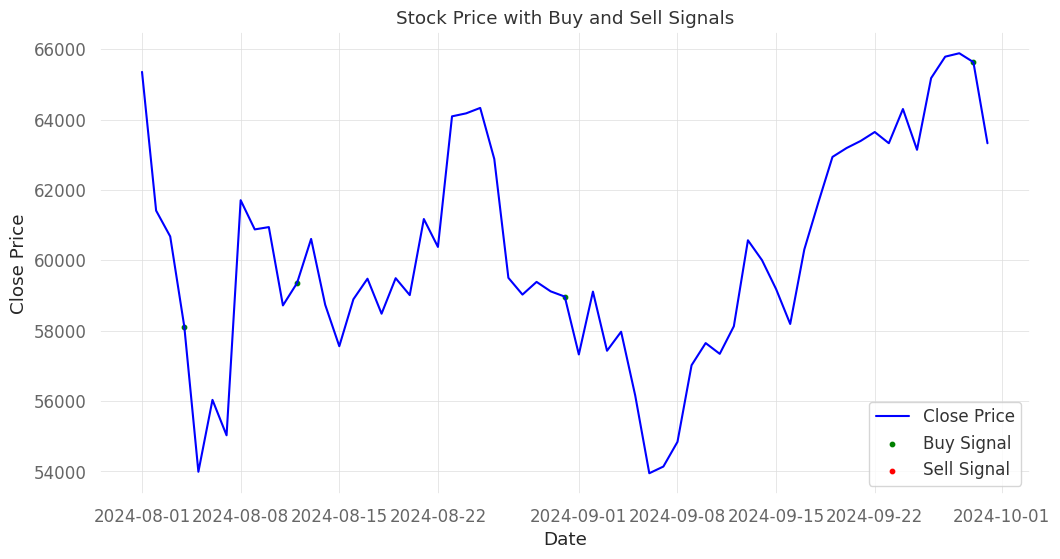

                    Strategy
------------------  ----------
Start Period        2024-08-01
End Period          2024-09-29
Risk-Free Rate      0.0%
Time in Market      95.0%

Cumulative Return   2.74%
CAGR﹪              12.25%

Sharpe              1.4
Prob. Sharpe Ratio  75.39%
Sortino             2.24
Sortino/√2          1.58
Omega               1.26

Max Drawdown        -3.95%
Longest DD Days     24

Gain/Pain Ratio     0.26
Gain/Pain (1M)      12.05

Payoff Ratio        1.06
Profit Factor       1.26
Common Sense Ratio  1.67
CPC Index           0.73
Tail Ratio          1.32
Outlier Win Ratio   2.89
Outlier Loss Ratio  2.53

MTD                 3.01%
3M                  2.74%
6M                  2.74%
YTD                 2.74%
1Y                  2.74%
3Y (ann.)           12.25%
5Y (ann.)           12.25%
10Y (ann.)          12.25%
All-time (ann.)     12.25%

Avg. Drawdown       -0.95%
Avg. Drawdown Days  5
Recovery Factor     0.7
Ulcer Index         0.01
Serenity Index      0.37


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


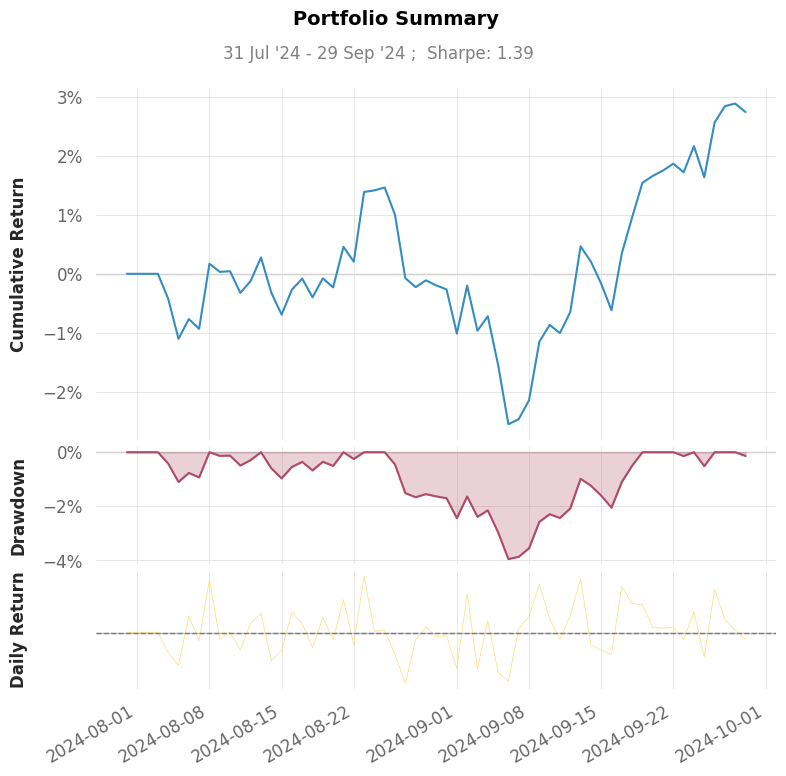

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


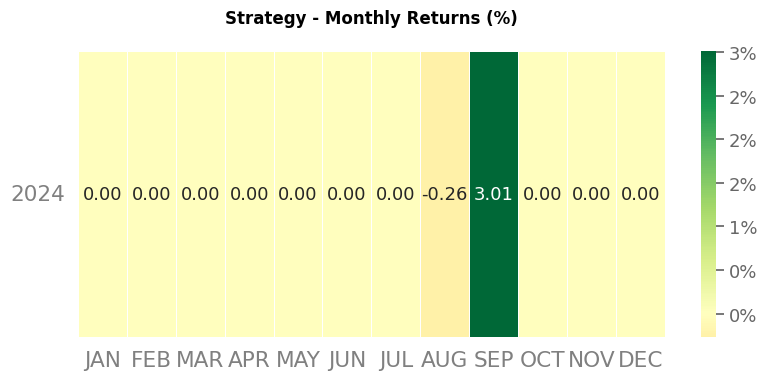

In [10]:
from matplotlib import pyplot as plt
import pandas as pd
from gym_anytrading.envs import Actions
import quantstats as qs

test_data = DataLoader('BTC-USD', '2024-08-01', '2024-10-01')

test_env = StockTradingEnv(test_data)
check_env(test_env)

portfolio_values = []

observation, info = test_env.reset()

while True:
    action, _states = model.predict(observation)

    observation, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    # env.render()
    portfolio_values.append(info['portfolio_value'])

    if done:
        break

actions_data = test_env.close()
actions_data.index = pd.to_datetime(test_data.frame.index)


print(actions_data.shape)
buy_signals = actions_data[actions_data['Action'] == 1]
sell_signals = actions_data[actions_data['Action'] == -1]

print(buy_signals.shape)
print(sell_signals.shape)

# Plot the closing prices
plt.figure(figsize=(12, 6))
plt.plot(actions_data.index, test_data.frame['Close'], label='Close Price', color='blue', linewidth=1.5)

# Plot buy signals (green dots)
plt.scatter(buy_signals.index, test_data.frame.loc[buy_signals.index, 'Close'], color='green', label='Buy Signal', marker='o', s=10)

# Plot sell signals (red dots)
plt.scatter(sell_signals.index, test_data.frame.loc[sell_signals.index, 'Close'], color='red', label='Sell Signal', marker='o', s=10)

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price with Buy and Sell Signals')
plt.legend()
plt.grid(True)
plt.show()

dates = pd.date_range(start=test_data.frame.index[0], periods=len(portfolio_values), freq="D")
portfolio_series = pd.Series(portfolio_values, index=dates)

returns = portfolio_series.pct_change().fillna(0)

qs.reports.basic(returns)


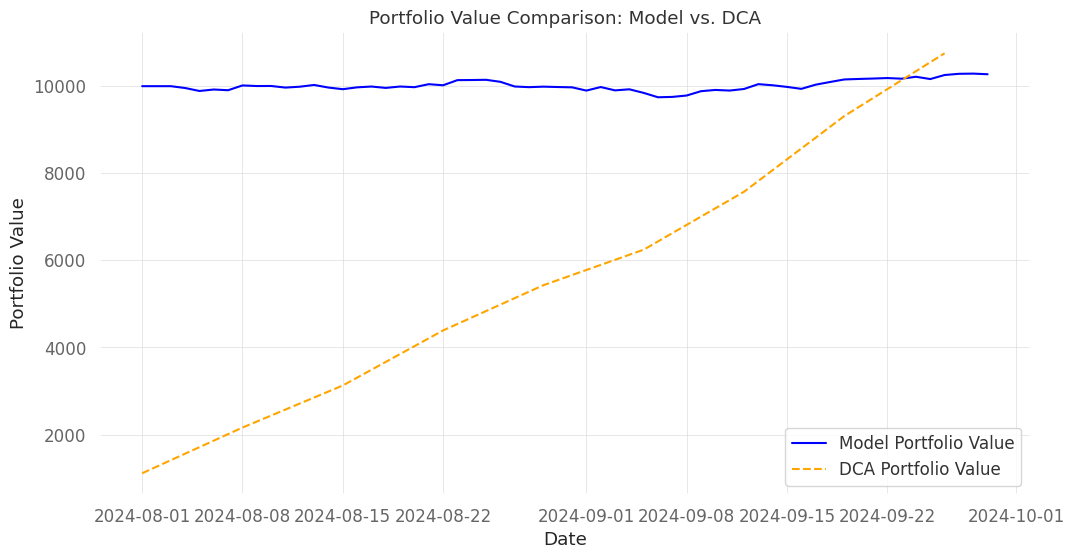

/home/tommy/ai-playground/.venv/lib/python3.12/site-packages/quantstats/utils.py:279: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2024-08-04   2024-08-04
End Period          2024-09-29   2024-09-29
Risk-Free Rate      0.0%         0.0%
Time in Market      13.0%        92.0%

Cumulative Return   397.92%      2.57%
CAGR﹪              137057.67%   12.08%

Sharpe              5.38         1.44
Prob. Sharpe Ratio  100.0%       75.3%
Sortino             -            2.27
Sortino/√2          -            1.61
Omega               1.28         1.28

Max Drawdown        -            -3.95%
Longest DD Days     -            -

Gain/Pain Ratio     -            0.28
Gain/Pain (1M)      -            6.34

Payoff Ratio        -            -
Profit Factor       -            1.28
Common Sense Ratio  -            1.6
CPC Index           -            -
Tail Ratio          -            1.25
Outlier Win Ratio   6.75         61.51
Outlier Loss Ratio  -            1.27

MTD                 72.23%       3.01%
3M                  397.

/home/tommy/ai-playground/.venv/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2285: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/tommy/ai-playground/.venv/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2286: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


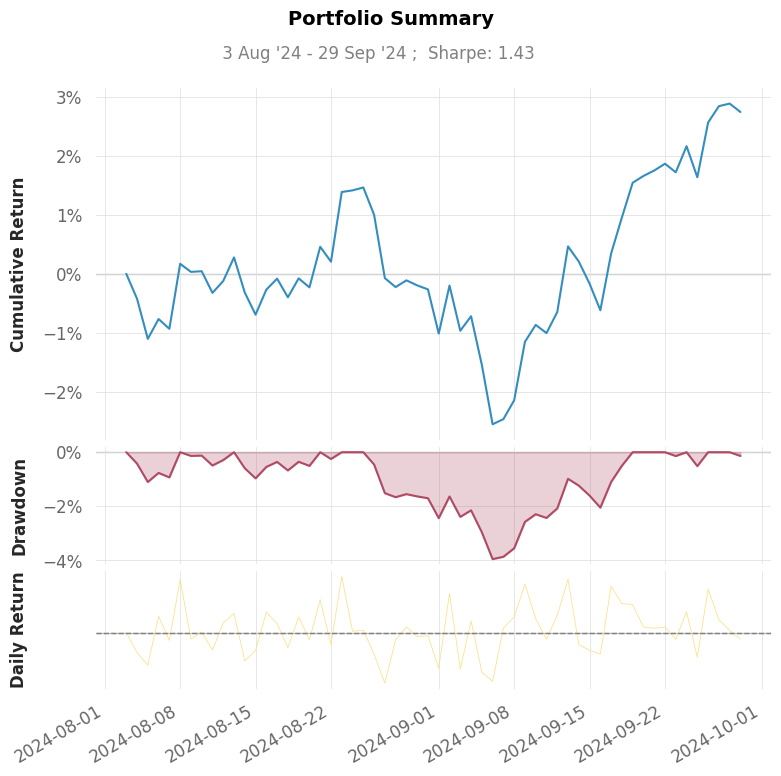

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


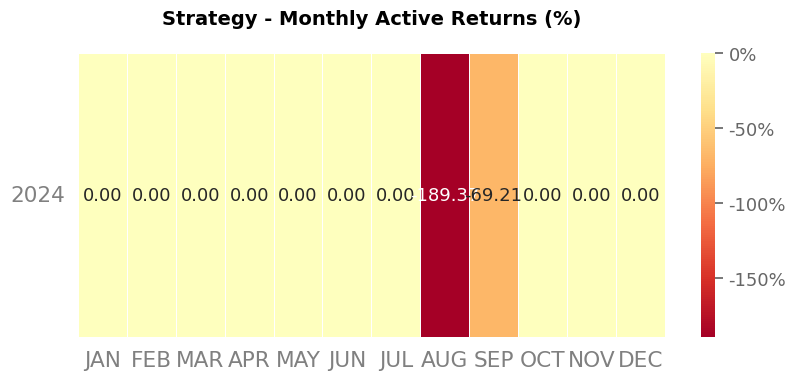